In [55]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
#read in data
df = pd.read_table("Datasets/schooldropout.csv", sep=';')

#encode Target variable as integers, with graduate = enrolled so there are 2 classes
df['Target'].replace(['Dropout', 'Graduate', 'Enrolled'], [0, 1, 1], inplace=True)

#split into train and test sets
trainX, testX, trainY, testY = train_test_split(df.drop('Target', axis=1), 
                                                df['Target'], test_size=0.3, random_state=0)


In [50]:
#can't visualize with 36 predictors and no useful components from FAMD
#try different kernal types, using default parameters, except dual in LinearSVC
#default dual=True is more applicable when n_samples < n_features

#linear
svmLinear = svm.SVC(kernel='linear')
fitLinear = svmLinear.fit(trainX, trainY)
testLinear = svmLinear.score(testX, testY)

#poly, degree = 3
svmSquare = svm.SVC(kernel='poly', degree=2)
fitSquare = svmSquare.fit(trainX, trainY)
testSquare = svmSquare.score(testX, testY)

#poly, degree = 3
svmCube = svm.SVC(kernel='poly', degree=3)
fitCube = svmCube.fit(trainX, trainY)
testCube = svmCube.score(testX, testY)

#radial
svmRadial = svm.SVC(kernel='rbf')
fitRadial = svmRadial.fit(trainX, trainY)
testRadial = svmRadial.score(testX, testY)

#sigmoid
svmSigmoid = svm.SVC(kernel='sigmoid')
fitSigmoid = svmSigmoid.fit(trainX, trainY)
testSigmoid = svmSigmoid.score(testX, testY)


In [51]:
print(testLinear)
print(testSquare)
print(testCube)
print(testRadial)
print(testSigmoid)


0.8697289156626506
0.677710843373494
0.677710843373494
0.677710843373494
0.6618975903614458


The linear kernel clearly produces the best accuracy, so let's tune the regularization parameter C:

In [56]:
#from https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/

def cross_validation(c):
      '''Function to perform 5 Folds Cross-Validation
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      trainX, testX, trainY, testY = train_test_split(df.drop('Target', axis=1), 
                                                df['Target'], test_size=0.3)
      
      model = svm.SVC(kernel='linear', C=c)

      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=trainX,
                               y=trainY,
                               cv=5,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [ ]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [59]:
cv_result = []

for c in [1, 10, 30, 60, 100]:
    cv_result.append(cross_validation(c))

KeyboardInterrupt: 

In [38]:
#confusion matrix
confusion_matrix(testY, model.predict(testX))

array([[295, 133],
       [ 50, 850]], dtype=int64)

2.1% false negative<br>
11.5% false positive<br>
Model has higher tendency to underestimate students' likelihood to dropout, might call it "conservative."

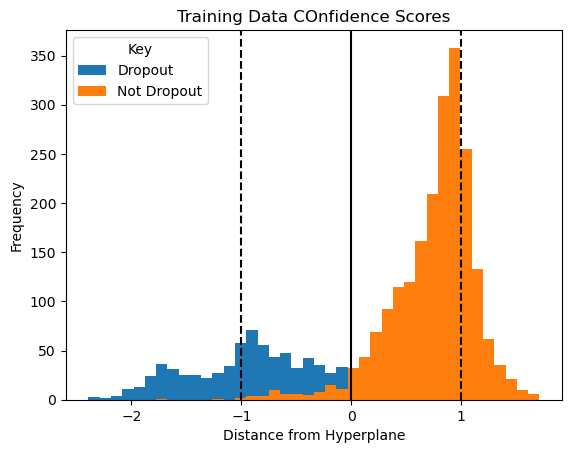

In [40]:
#plot confidence scores of training data
trainConfidence = pd.DataFrame(data={'Key': trainY.replace([0,1],['Dropout', 'Not Dropout']), 
                                     'Dist': model.decision_function(trainX)})
trainConfidence.pivot(columns='Key', values='Dist').plot.hist(bins=40)
plt.axvline(x=-1, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')
plt.axvline(x=0, color='k')
plt.xlabel('Distance from Hyperplane')
plt.title('Training Data Confidence Scores')
plt.show()

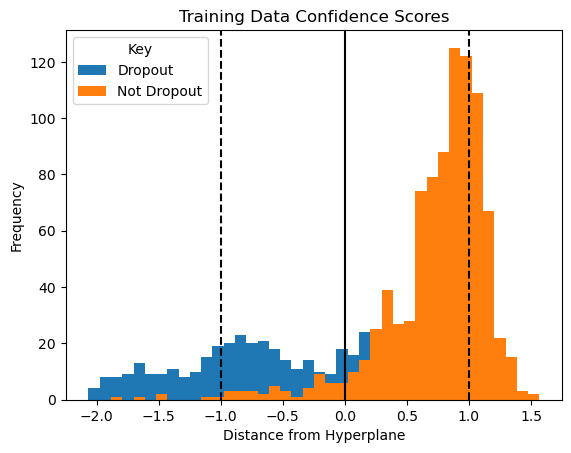

In [41]:
#plot confidence scores of testing data
testConfidence = pd.DataFrame(data={'Key': testY.replace([0,1],['Dropout', 'Not Dropout']), 
                                     'Dist': svm1.decision_function(testX)})
testConfidence.pivot(columns='Key', values='Dist').plot.hist(bins=40)
plt.axvline(x=-1, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')
plt.axvline(x=0, color='k')
plt.xlabel('Distance from Hyperplane')
plt.title('Testing Data Confidence Scores')
plt.show()

In [ ]:
#which factors matter the most?